# Use a pre-trained U-Net with the ```segmentation-models``` module

In [74]:
import cv2
import glob
import imageio
import os
import matplotlib.pyplot as plt
import numpy as np
import napari

X_train_p, Y_train_p = "D:/Hugo/Budding/Train_Set/aug_images", "D:/Hugo/Budding/Train_Set/aug_masks"
# X_val_p, Y_val_p = "D:/Hugo/Budding/Test_Set/images", "D:/Hugo/Budding/Test_Set/masks"

def load_data(directory):
    l = []
    print(f"Loading images from {directory}")
    for im in os.listdir(directory):
        image = np.asarray(imageio.imread(os.path.join(directory, im)))
        l.append(image)
    print(f"Read {len(l)} images from directory.")
    return np.array(l)

def preprocess_data(images, target_dim=(512, 512), n_channels=1):
    # resize
    reshaped = []
    for im in images:
        reshaped.append(cv2.resize(im, target_dim))

    # scale
    scaled = []
    for res in reshaped:
        scaled.append(res / np.max((res.max(), 1)))
    scaled = np.array(scaled)

    # expand dims
    preprocessed = np.expand_dims(scaled, axis=-1)
    if n_channels == 3:
        preprocessed = np.concatenate([preprocessed, preprocessed, preprocessed], axis=-1)

    return preprocessed

x_train, y_train = preprocess_data(load_data(X_train_p), n_channels=3),  preprocess_data(load_data(Y_train_p))
# x_val, y_val = load_from_dir(X_val_p), load_from_dir(Y_val_p)

Loading images from D:/Hugo/Budding/Train_Set/aug_images
Read 729 images from directory.
Loading images from D:/Hugo/Budding/Train_Set/aug_masks
Read 729 images from directory.


<ipython-input-74-14b577c855b7>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(l)


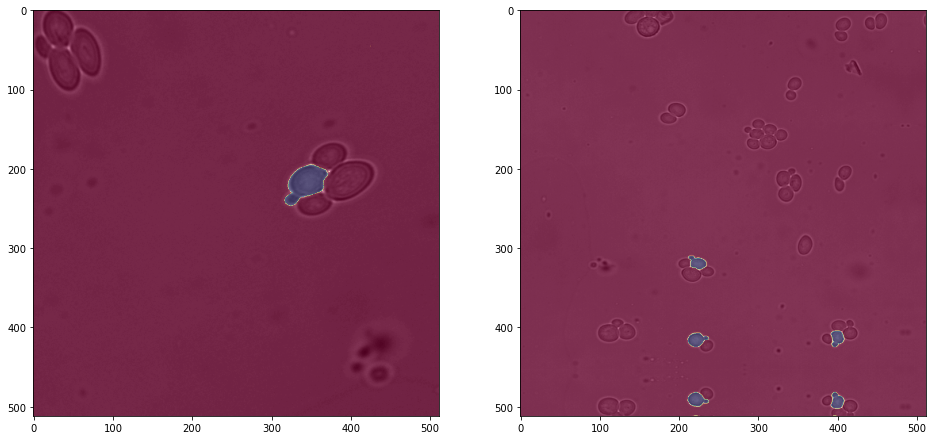

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
for ax, im, ms in zip(axes, x_train, y_train):
    ax.imshow(im, cmap="Greys")
    ax.imshow(ms, cmap="Spectral", alpha=0.5)

In [76]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

import tensorflow.keras as keras
keras.backend.set_image_data_format('channels_last')

BACKBONE = 'resnet34'

# preprocess input
# preprocess_input = get_preprocessing(BACKBONE)
# x_train, y_train = preprocess_input(x_train), preprocess_input(x_val)
# x_val = preprocess_input(x_val), preprocess_input(x_val)

# define model
model = Unet(BACKBONE, input_shape=(512, 512, 3), 
             encoder_weights='imagenet', encoder_freeze=True, 
             activation="sigmoid", classes=1, decoder_filters=(1024, 512, 256, 128, 64))

print(model.summary())

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 512, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_306 (ZeroPadding (None, 518, 518, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 256, 64) 9408        zero_padding2d_306[0][0]         
___________________________________________________________________________________________

In [77]:
model.compile(keras.optimizers.Adam(learning_rate=0.001), loss=bce_jaccard_loss, metrics=[iou_score])

# fit model
history=model.fit(
    x=x_train,
    y=y_train,
    batch_size=4,
    epochs=25,
)

Epoch 1/25
183/183 [==============================] - 106s 581ms/step - loss: 1.0093 - iou_score: 0.0608
Epoch 2/25
183/183 [==============================] - 108s 589ms/step - loss: 0.9534 - iou_score: 0.1052
Epoch 3/25
183/183 [==============================] - 108s 589ms/step - loss: 0.9203 - iou_score: 0.1364
Epoch 4/25
183/183 [==============================] - 108s 589ms/step - loss: 0.8916 - iou_score: 0.1630
Epoch 5/25
183/183 [==============================] - 108s 588ms/step - loss: 0.8651 - iou_score: 0.1894
Epoch 6/25
183/183 [==============================] - 108s 588ms/step - loss: 0.8482 - iou_score: 0.2045
Epoch 7/25
183/183 [==============================] - 107s 585ms/step - loss: 0.8401 - iou_score: 0.2132
Epoch 8/25
183/183 [==============================] - 107s 585ms/step - loss: 0.8208 - iou_score: 0.2301
Epoch 9/25
183/183 [==============================] - 107s 585ms/step - loss: 0.8071 - iou_score: 0.2442
Epoch 10/25
183/183 [==============================] - 

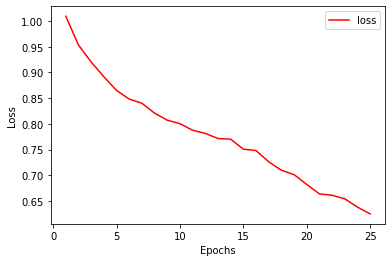

In [78]:
loss = history.history["loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label="loss", c="r")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Check predictions

In [79]:
# Check predictions
X_test_p = "D:/Hugo/Budding/Test_Set/images"
test_set = preprocess_data(load_data(X_test_p), n_channels=3)
print(test_set.shape)

contaminated = False
train_dir = os.listdir("D:/Hugo/Python_Scripts/Tools/unet/training_sets/budding/images")
for test_im in os.listdir("D:/Hugo/Budding/Test_Set/images"):
    if test_im in train_dir:
        contaminated = True
        print(f"Image {test_im} used for evaluation was found in the training set.")
        
if not contaminated:
    print("Test set is clean.")

subset = 10
predictions = model.predict(test_set[subset:])

Loading images from D:/Hugo/Budding/Test_Set/images
Read 22 images from directory.
(22, 512, 512, 3)
Test set is clean.


In [80]:
with napari.gui_qt():
    viewer = napari.view_image(test_set[subset:])
    viewer.add_image(predictions, blending="additive")

In [ ]:
# Save model
save_path = "D:/Hugo/Budding/Models/"
os.chdir(save_path)
keras.save_model("U-Net_pretrained_Resnet34_encoder_65_images")